# Binarization investigation experiment

In this notebook, we try to understand the importance of the binarization algorithm with varying quality of originals and fakes CDP.

In [18]:
import numpy as np
from lib.Dataset_cdp import Dataset_cdp
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve, roc_auc_score
import json

from lib.predictor_functions import batch_train_codebook, pool_predict, apply_otsu_threshold
from lib.cdp_metrics import batch_metric
import os

In [19]:
src = "/media/tuttj/phd_data/datasets/pattern_reliability_tifs_2023/scanner/run_1/original/"
miss = []

for i in range(1440):
    if not os.path.exists(src + f'{i+1}'.zfill(6) + '.tiff'):
        miss.append(i+1)


In [3]:
print(miss)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [5]:
dset_scan_0 = Dataset_cdp(dataset_name='scanner', run=0, nb_samples=720, load_unet=False)
dset_scan_1 = Dataset_cdp(dataset_name='scanner', run=1, nb_samples=1440, load_unet=False)
dset_iphone = Dataset_cdp(dataset_name='iphone', run=1, nb_samples=1440, load_unet=False)
dset_samsung = Dataset_cdp(dataset_name='samsung', run=1, nb_samples=1440, load_unet=False)

Removed sample 8
Removed sample 9
Removed sample 10
Removed sample 25
Removed sample 26
Removed sample 28
Removed sample 29
Removed sample 37
Removed sample 49
Removed sample 55
Removed sample 61
Removed sample 73
Removed sample 75
Removed sample 78
Removed sample 79
Removed sample 85
Removed sample 96
Removed sample 97
Removed sample 104
Removed sample 109
Removed sample 120
Removed sample 121
Removed sample 125
Removed sample 132
Removed sample 133
Removed sample 142
Removed sample 144
Removed sample 145
Removed sample 147
Removed sample 158
Removed sample 159
Removed sample 169
Removed sample 181
Removed sample 187
Removed sample 193
Removed sample 195
Removed sample 196
Removed sample 198
Removed sample 199
Removed sample 205
Removed sample 207
Removed sample 217
Removed sample 218
Removed sample 222
Removed sample 228
Removed sample 229
Removed sample 237
Removed sample 238
Removed sample 240
Removed sample 241
Removed sample 242
Removed sample 243
Removed sample 244
Removed sampl

In [6]:
i = 0

samples = {}

for dset in [dset_scan_0, dset_scan_1, dset_iphone, dset_samsung]:
    loader = DataLoader(dset, batch_size=len(dset), shuffle=False)
    for data in loader:
        for key in data.keys():
            data[key] = np.asarray(data[key])

    if i in [0, 1]:
        samples[f'scan_{i}'] = data

    if i == 2:
        samples['iphone'] = data

    if i == 3:
        samples['samsung'] = data

    i += 1

TypeError: Invalid shape () for image data

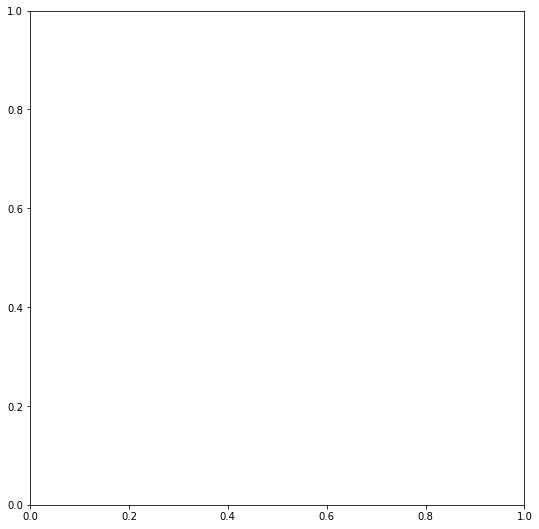

In [70]:
i = 3

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(samples['scan_0']['x'][i] > threshold['scan_0']['x'][i], cmap='gray')
plt.title('x_scan_0')
plt.subplot(222)
plt.imshow(samples['scan_1']['x'][i] > threshold['scan_1']['x'][i], cmap='gray')
plt.title('x_scan_1')
plt.subplot(223)
plt.imshow(samples['scan_0']['f'][i] > threshold['scan_0']['f'][i], cmap='gray')
plt.title('f_scan_0')
plt.subplot(224)
plt.imshow(samples['scan_1']['f'][i] > threshold['scan_1']['f'][i], cmap='gray')
plt.title('f_scan_1')
plt.show()

In [8]:
from skimage.filters import threshold_otsu
from tqdm import trange

threshold = {}

for key in samples.keys():
    t = {}
    for name in samples[key].keys():
        l = []
        for i in trange(samples[key][name].shape[0]):
            l += [threshold_otsu(samples[key][name][i])]

        t[name] = l

    threshold[key] = t

100%|██████████| 1145/1145 [00:00<00:00, 2013.69it/s]


(array([ 39.,  32.,  54.,  41.,  59., 234., 245., 251., 163.,  27.]),
 array([0.43164062, 0.4363281 , 0.44101563, 0.44570312, 0.45039064,
        0.45507812, 0.4597656 , 0.46445313, 0.46914062, 0.47382814,
        0.47851562], dtype=float32),
 <BarContainer object of 10 artists>)

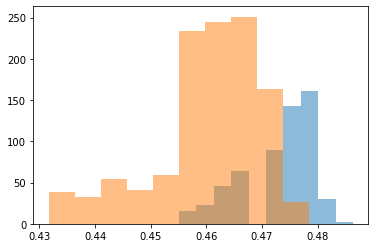

In [40]:
#plt.hist(threshold['scan_0']['x'], alpha=.5)
#plt.hist(threshold['scan_1']['x'], alpha=.5)
plt.hist(threshold['scan_0']['f'], alpha=.5)
plt.hist(threshold['scan_1']['f'], alpha=.5)

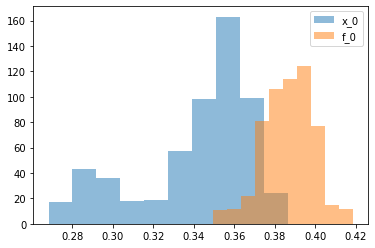

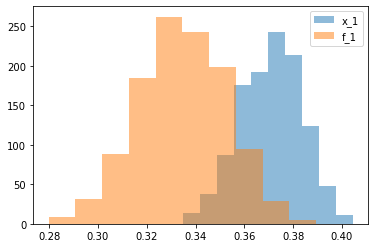

In [59]:
plt.figure()
plt.hist(samples['scan_0']['x'].reshape([-1,684**2]).mean(-1), alpha=.5, label='x_0')
plt.hist(samples['scan_0']['f'].reshape([-1,684**2]).mean(-1), alpha=.5, label='f_0')
plt.legend()
plt.show()

plt.figure()
plt.hist(samples['scan_1']['x'].reshape([-1,684**2]).mean(-1), alpha=.5, label='x_1')
plt.hist(samples['scan_1']['f'].reshape([-1,684**2]).mean(-1), alpha=.5, label='f_1')
plt.legend()
plt.show()

(array([161515.,  13664.,   9999.,   8410.,   7621.,   6995.,   6543.,
          6151.,   5937.,   5586.,   5289.,   5039.,   4996.,   4767.,
          4656.,   4589.,   4519.,   4553.,   4293.,   4284.,   4106.,
          4111.,   4007.,   3925.,   4028.,   3946.,   3830.,   3765.,
          3900.,   3730.,   3733.,   3777.,   3789.,   3777.,   3799.,
          3759.,   3940.,   3819.,   3974.,   3856.,   3843.,   4174.,
          4218.,   4292.,   4537.,   5004.,   5295.,   5998.,   7371.,
         66147.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

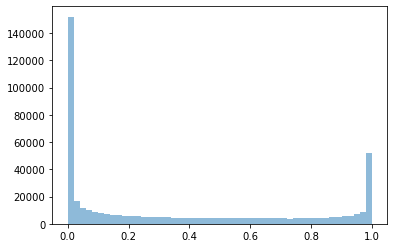

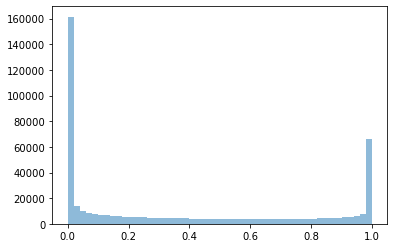

In [63]:
plt.hist(samples['scan_0']['x'][0].reshape([-1]), alpha=.5, label='x_0', bins=50)
plt.figure()
plt.hist(samples['scan_1']['x'][0].reshape([-1]), alpha=.5, label='x_1', bins=50)

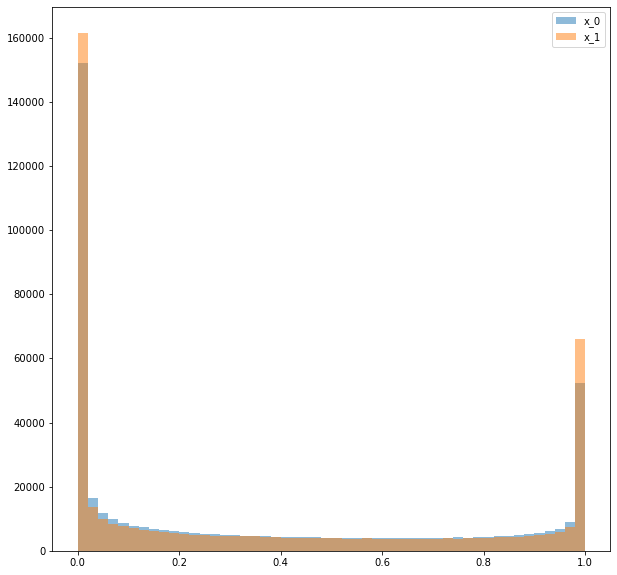

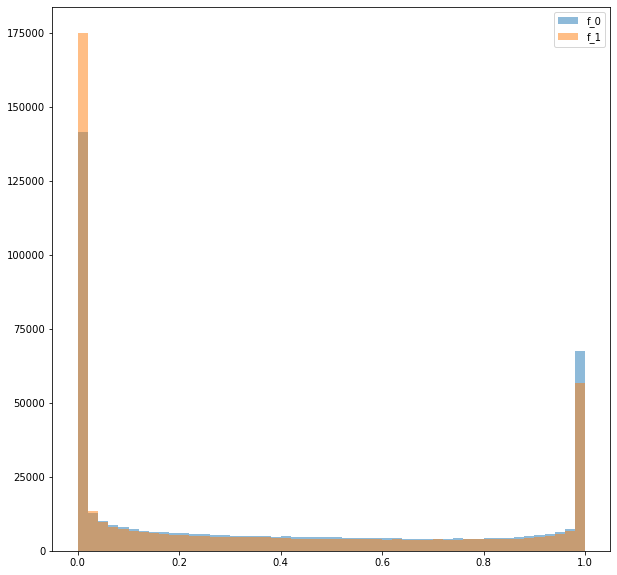

In [67]:
plt.figure(figsize=(10,10))
plt.hist(samples['scan_0']['x'][0].reshape([-1]), alpha=.5, label='x_0', bins=50)
plt.hist(samples['scan_1']['x'][0].reshape([-1]), alpha=.5, label='x_1', bins=50)
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.hist(samples['scan_0']['f'][0].reshape([-1]), alpha=.5, label='f_0', bins=50)
plt.hist(samples['scan_1']['f'][0].reshape([-1]), alpha=.5, label='f_1', bins=50)
plt.legend()
plt.show()

In [29]:
print('scan_0', 'x', np.mean(samples['scan_0']['x']))
print('scan_1', 'x', np.mean(samples['scan_1']['x']))
print('scan_0', 'f', np.mean(samples['scan_0']['f']))
print('scan_1', 'f', np.mean(samples['scan_1']['f']))

scan_0 x 0.34150398
scan_1 x 0.38676357
scan_0 f 0.37091932
scan_1 f 0.3346264


In [55]:
print('scanner 0')
print('orig', np.mean(samples['scan_0']['x']))
print('fake', np.mean(samples['scan_0']['f']))
print('')
print('scanner 1')
print('orig', np.mean(samples['scan_1']['x']))
print('fake', np.mean(samples['scan_1']['f']))

scanner 0
orig 0.34150398
fake 0.38676357

scanner 1
orig 0.37091932
fake 0.3346264


In [56]:
print('iphone 1')
print('orig', np.mean(samples['iphone']['x']))
print('fake', np.mean(samples['iphone']['f']))

iphone 1
orig 0.26154375
fake 0.23983546


In [57]:
print('samsung 1')
print('orig', np.mean(samples['samsung']['x']))
print('fake', np.mean(samples['samsung']['f']))

samsung 1
orig 0.20188847
fake 0.17731422
